In [291]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [292]:
# this command will download the LFW_people's dataset to hard disk.
lfw_people = fetch_lfw_people(data_home='D:\Senior II\Image Processing\Project\LFW Dataset',
min_faces_per_person = 70, resize = 0.4)

In [293]:
images = lfw_people.images
print('Images shape:',images.shape)

m, h, w = images.shape
print('M = Number of examples = ',m)
print(f'Each image has size: {h} x {w}')

n_features = h*w
print(f'N^2 = n_features = h x w = {n_features}')

y = lfw_people.target
print('y has shape:', y.shape)

target_names = lfw_people.target_names
num_people = target_names.shape[0]
print('Number of people =', num_people)

Images shape: (1288, 50, 37)
M = Number of examples =  1288
Each image has size: 50 x 37
N^2 = n_features = h x w = 1850
y has shape: (1288,)
Number of people = 7


In [328]:
print(target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [294]:
#Key: person ID
#Value: person image index
person_image_dict = dict()
for image_index in range(m):
    if (y[image_index] not in person_image_dict.keys()):
        person_image_dict[y[image_index]] = [image_index]
    else:
        person_image_dict[y[image_index]].append(image_index)

Gerhard Schroeder


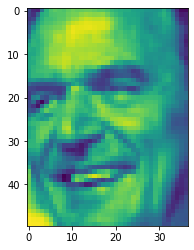

In [295]:
#View an image
index = int(random.random() * m)
name = target_names[y[index]]
print(name)
plt.imshow(images[index,:,:])
plt.show()

In [296]:
#Flatten images array
flattened_images = images.reshape(m, -1).T
# N^2 * M
# Each column is an image
print(f'Shape after flattening: {flattened_images.shape}')

Shape after flattening: (1850, 1288)


Flattened Average image has shape: (1850, 1)
Average Face


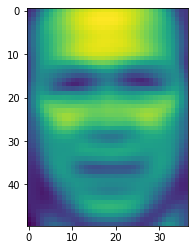

In [297]:
# In all corresponding pixels in all images, we calculate the average
average_image = np.mean(flattened_images, axis = 1)
average_image = average_image.reshape(h, w)
flattened_average_image = average_image.reshape(-1, 1)
print(f'Flattened Average image has shape: {flattened_average_image.shape}')
print('Average Face')
plt.imshow(average_image)
plt.show()

Shape after subtracting average face: (1850, 1288)
Colin Powell


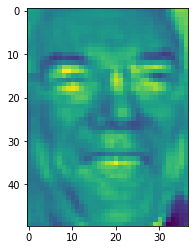

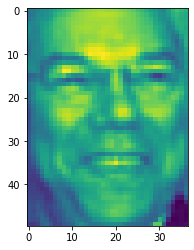

In [298]:
# Subtract the average image from all images
# This is done to remove the average face from all images
# N^2 * M
difference_images = flattened_images - average_image.reshape(-1, 1)
print(f'Shape after subtracting average face: {flattened_images.shape}')

# Show one of the difference images
index = int(random.random() * m)
name = target_names[y[index]]
print(name)
plt.imshow(difference_images[:,index].reshape(h, w))
plt.show()
# Print original image
plt.imshow(images[index,:,:])
plt.show()

In [299]:
# Get the covariance matrix C 
# C = A * A^T where A = [difference_images[0], difference_images[1], ..., difference_images[M-1]]

A = difference_images
print('Shape of A:', A.shape)

covariance_matrix = np.matmul(difference_images, difference_images.T)
# N^2 * N^2
print('Shape of covariance matrix:', covariance_matrix.shape)

Shape of A: (1850, 1288)
Shape of covariance matrix: (1850, 1850)


In [300]:
# Calculate the eigenvalues and eigenvectors of L
# where L = A^T * A

L = np.matmul(A.T, A)
# M * M
print('Shape of L:', L.shape)

# M eigenvalues and M eigenvectors
# where M is the number of examples

eigenvalues, eigenvectors = np.linalg.eig(L)
print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of eigenvectors:', eigenvectors.shape)


Shape of L: (1288, 1288)
Shape of eigenvalues: (1288,)
Shape of eigenvectors: (1288, 1288)


In [301]:
# Those Eigenvectors detdetermine linear combinations of the M training set face images 
# to form the eigenfaces U

# differences: N^2 * M
# differences[:, i, np.newaxis]: N^2 * 1
# eigenvectors: M * M
# eigenvectors[:, i, np.newaxis]: M * 1
# eigenvectors[:, i, np.newaxis].T: 1 * M



eigenfaces = np.zeros((n_features, m))
# TODO optimize the for loop
for i in range(m):
    eigenfaces += np.matmul(difference_images[:, i, np.newaxis], eigenvectors[:, i, np.newaxis].T)


# N^2 * M
print('Shape of eigenfaces:', eigenfaces.shape)


Shape of eigenfaces: (1850, 1288)


George W Bush


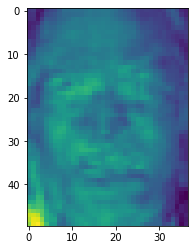

In [302]:
# Show one of the eigenfaces
index = int(random.random() * m)
name = target_names[y[index]]
print(name)
plt.imshow(eigenfaces[:,index].reshape(h, w))
plt.show()


In [377]:
# For each person, get one image from flattened_images
# Calculate the weigths w
omegas = np.zeros((num_people, m))

for person in range(num_people):
    #get an image of the person
    image_index = person_image_dict[person][0]
    image = flattened_images[:, image_index, np.newaxis]
    
    # calculate the weights
    for i in range(m):
        omegas[person, i] = np.matmul(eigenfaces[:, i, np.newaxis].T , image - flattened_average_image)

## Testing

In [355]:
# New test image
# index = int(random.random() * images.shape[0])
index = 14
#take on image from A randomly
test_image = flattened_images[:,index, np.newaxis]
print(f'Test image has shape: {test_image.shape}')

Test image has shape: (1850, 1)
4
It is the image of Gerhard Schroeder


In [356]:
# Calculate the weigths w
w = np.zeros((m,))
for i in range(m):
    w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T, test_image - flattened_average_image)


In [358]:
# Calculate the distance between the test image and the image of the person
# The person with the smallest distance is the person in the test image

min_distance = float('inf')
nearest_person = -1

for person in range(num_people):
    distance = np.linalg.norm(w - omegas[person, :])
    if(distance < min_distance):
        min_distance = distance
        nearest_person = person
    print(f'Distance between test image and {target_names[person]} is {distance}')

threshold = float('inf')
if (min_distance < threshold):
    print(f'The nearest person is {target_names[nearest_person]}')
    print(f'True person: {target_names[y[index]]}')
else:
    print('No person found')


Distance between test image and Ariel Sharon is 606.6917813472545
Distance between test image and Colin Powell is 423.7533614309459
Distance between test image and Donald Rumsfeld is 657.139118595227
Distance between test image and George W Bush is 291.5210402499774
Distance between test image and Gerhard Schroeder is 349.7422893268433
Distance between test image and Hugo Chavez is 296.4646618583819
Distance between test image and Tony Blair is 544.8969579608204
The nearest person is George W Bush
True person: Gerhard Schroeder
